In [2]:
!pip install jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import PIL
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers.legacy import adam


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip "/content/soils.zip"

In [4]:

import pathlib

data_dir = pathlib.Path("/content/soils/")


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

440


In [6]:
batch_size = 32
img_height = 256
img_width = 256

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 3 classes.
Using 352 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 3 classes.
Using 88 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['clay', 'gravel', 'sand']


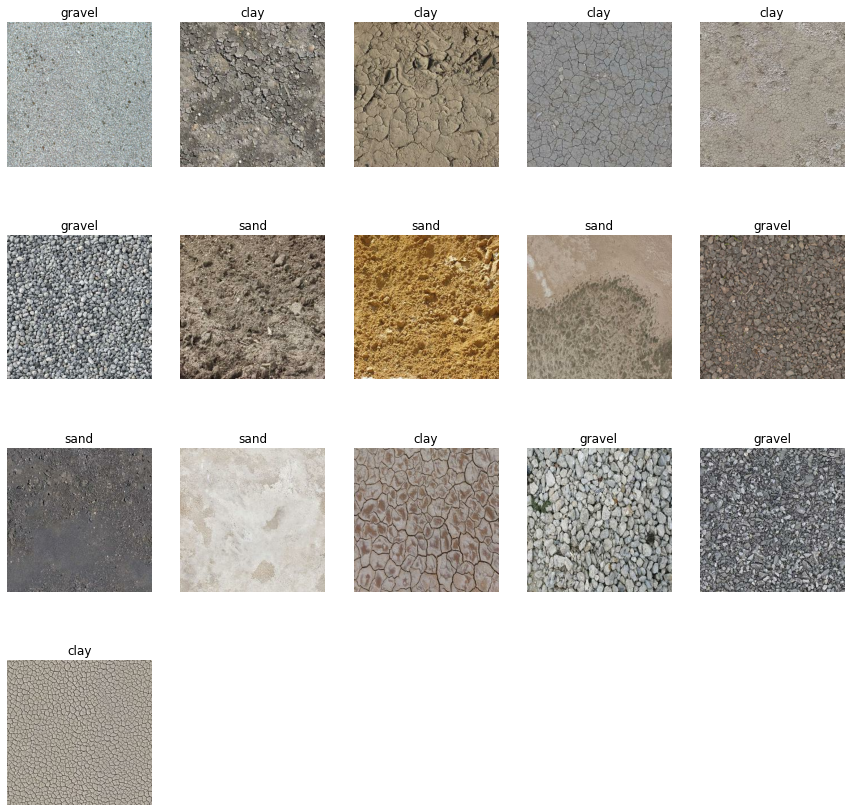

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)


In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = jnp.array(image_batch[0])  
# Notice the pixel values are now in `[0,1]`.
print(jnp.min(first_image), jnp.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 1.0


In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax'),
  
])

In [21]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs=80
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/80


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 2s 82ms/step - loss: 3.9783 - accuracy: 0.3494 - val_loss: 1.0992 - val_accuracy: 0.1705
Epoch 2/80
11/11 [==============================] - 1s 60ms/step - loss: 1.1042 - accuracy: 0.3466 - val_loss: 1.0972 - val_accuracy: 0.4773
Epoch 3/80
11/11 [==============================] - 1s 61ms/step - loss: 1.0837 - accuracy: 0.3580 - val_loss: 1.1372 - val_accuracy: 0.2386
Epoch 4/80
11/11 [==============================] - 1s 63ms/step - loss: 1.0067 - accuracy: 0.4858 - val_loss: 1.1097 - val_accuracy: 0.3182
Epoch 5/80
11/11 [==============================] - 1s 62ms/step - loss: 0.9276 - accuracy: 0.5455 - val_loss: 1.1662 - val_accuracy: 0.3409
Epoch 6/80
11/11 [==============================] - 1s 62ms/step - loss: 0.9432 - accuracy: 0.5199 - val_loss: 1.0442 - val_accuracy: 0.3523
Epoch 7/80
11/11 [==============================] - 1s 61ms/step - loss: 0.8640 - accuracy: 0.5483 - val_loss: 1.2531 - val_accuracy: 0.3068
Epoch 8/80
11/11 [======

KeyboardInterrupt: ignored

In [18]:
loss, accuracy = model.evaluate(val_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 18ms/step - loss: 2.1343 - accuracy: 0.5568
Loss:  2.1342520713806152
Accuracy:  0.5568181872367859


In [ ]:
model.save("soil.h5")

In [ ]:
model.save_weights('soil_weights.h5')


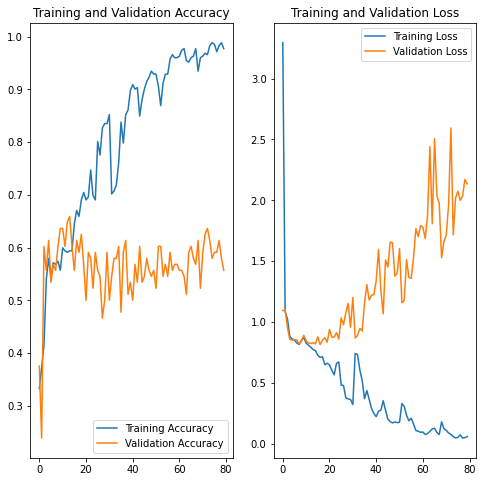

In [19]:
conacc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, conacc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()